In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
#scer annotations from http://www.saccharomycessensustricto.org/current/Scer/Scer.gff

gff = '/Users/clairedubin/sacc/carly_genes/Scer.gff.txt'

annotation_dict = {}

for line in open(gff, 'r').readlines():
    
    if 'CDS' not in line:
        
        continue
        
    gene = line.split('SGD=')[1].split(';')[0]
    chrom, start, stop, direction = line.split('\t')[0], line.split('\t')[3], line.split('\t')[4], line.split('\t')[6]
    
    annotation_dict[gene] = [int(chrom), int(start), int(stop), direction]
    
annotation_dict
    

{'YAL069W': [5, 569954, 570016, '-'],
 'YAL068W-A': [1, 652, 789, '+'],
 'YGL261C': [7, 6290, 6652, '-'],
 'YOR394W': [16, 7933, 8427, '-'],
 'YBL108W': [2, 8177, 8482, '+'],
 'YAL067W-A': [1, 2495, 2704, '+'],
 'YML132W': [12, 1061667, 1061783, '+'],
 'YFL062W': [14, 8330, 9475, '+'],
 'YAL067C': [1, 7235, 9016, '-'],
 'YAL066W': [1, 10091, 10399, '+'],
 'YAL063C': [1, 203403, 208016, '+'],
 'YAL064W-B': [1, 12046, 12426, '+'],
 'YFR015C': [12, 660716, 662833, '+'],
 'YAL064C-A': [1, 13363, 13743, '-'],
 'YAR050W': [8, 538939, 539121, '+'],
 'YAR061W': [1, 13953, 13991, '-'],
 'YHR212W-A': [8, 538742, 538933, '+'],
 'YAR060C': [8, 537759, 538094, '-'],
 'YMR316W': [13, 904825, 905835, '+'],
 'YAR062W': [8, 539151, 539747, '+'],
 'YAL064W': [8, 530762, 531078, '-'],
 'YAL063C-A': [1, 22395, 22685, '-'],
 'YAR053W': [8, 528972, 529130, '+'],
 'YOR375C': [1, 31567, 32940, '+'],
 'YAL061W': [1, 33448, 34701, '+'],
 'YAL060W': [10, 731460, 731729, '-'],
 'YAL059W': [1, 36509, 37147, '+'],


In [4]:
#parsing function from melanie
def ParseG1(g1_file):
    '''
    Input: outfile from sweepfinder 2
    Output: 
    '''
    pos_list=[]
    G1_list=[]
    ratioG2G1_list=[]
    g_dict = {}
        
    #add position and values for each base to a dictionary for that chromosome
    f = open(g1_file)
    next(f)
    for line in f:
        row_data = line.strip().split("\t")
        peak_ctr=int(row_data[0])

        g_dict[peak_ctr] = float(row_data[6])
 
    f.close()
    return g_dict

In [59]:
def make_df(all_g1):

    for _,i in enumerate(all_g1):
        if _==0:
            df = pd.DataFrame.from_dict(all_g1[i], orient='index', columns=['G1'])
            df['chrom'] = [i for _ in all_g1[i].keys()]
        else:
            temp = pd.DataFrame.from_dict(all_g1[i], orient='index', columns=['G1'])
            temp['chrom'] = [i for _ in all_g1[i].keys()]
            df = df.append(temp)
            
    return df.reset_index().rename(columns={'index':'pos'})

In [153]:
#graphs for ORFs +/- 3kb

def make_g1_plot(g1, genes, title=None):

    fig = plt.figure(figsize=(15, len(genes)*5))
    fig.subplots_adjust(hspace=0.8, wspace=0.4)

    for _, gene in enumerate(genes):

        fig = plt.figure(figsize=(15, 5))

        chrom, start, stop, direction = annotation_dict[gene]

        locs = g1[(g1['chrom']==int(chrom)) & g1['pos'].isin(range(int(start)-3000,int(stop)+3000))]
        locs = locs[locs['G1'] > 0]

        #G1 plotting
        ax = fig.subplots()
        ax.scatter(locs['pos'].astype(int),locs['G1'],color='blue',s=10)
        ax.set_xlabel('Position on chromosome '+str(chrom), fontname="Arial", fontsize=18)
        ax.set_ylabel('G1', fontname="Arial", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        
        padding = (locs['G1'].max()-locs['G1'].min())/10

        ax.set_ylim(locs['G1'].min()-padding, locs['G1'].max()+padding)
        

        #ORF bar plotting
        height = padding/4

        orf = mpl.patches.Rectangle((start, locs['G1'].min()-padding), 
                                         stop-start, height, color ='black')        
        
        right = mpl.patches.Rectangle((stop,locs['G1'].min()-padding), 
                                         3000, height, color ='lightgray')
        left = mpl.patches.Rectangle((start-3000, locs['G1'].min()-padding), 
                                         3000, height, color ='lightgray')       
        ax.add_patch(orf)
        ax.add_patch(right)
        ax.add_patch(left)
        
#         if not title:
#             plt.title(gene, fontsize=16)
            
#         else:
#             plt.title(title, fontsize=16)

        fig.savefig('/Users/clairedubin/Desktop/{}_g1_plot_bigwindows.png'.format(title),format='png')


<Figure size 1080x360 with 0 Axes>

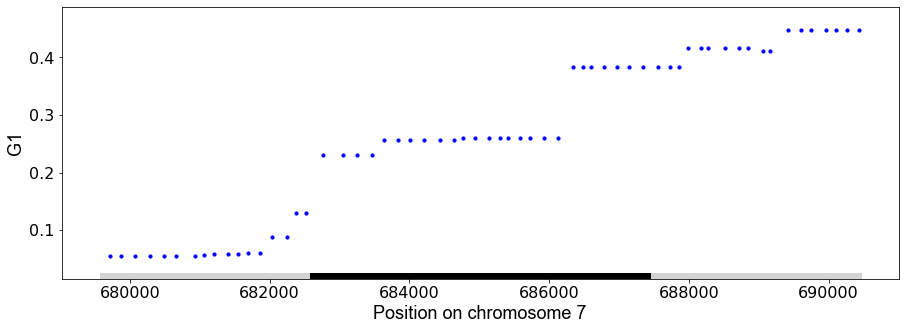

<Figure size 1080x360 with 0 Axes>

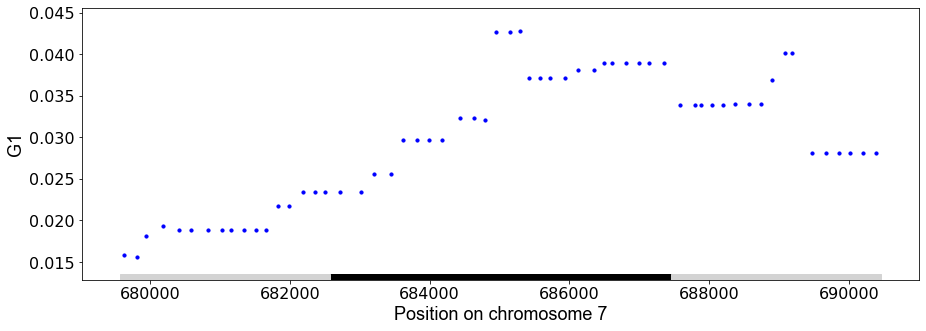

<Figure size 1080x360 with 0 Axes>

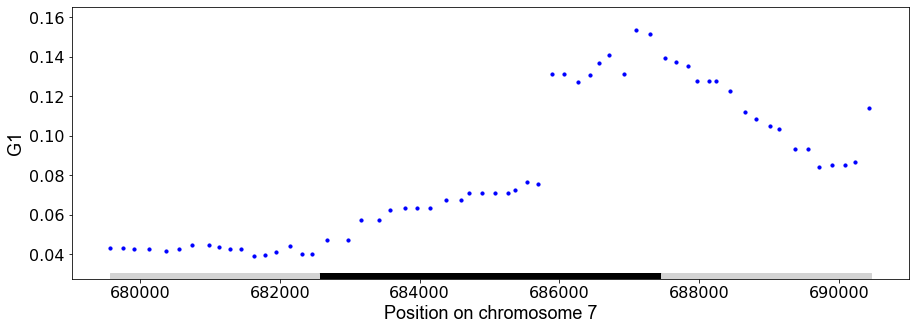

<Figure size 1080x360 with 0 Axes>

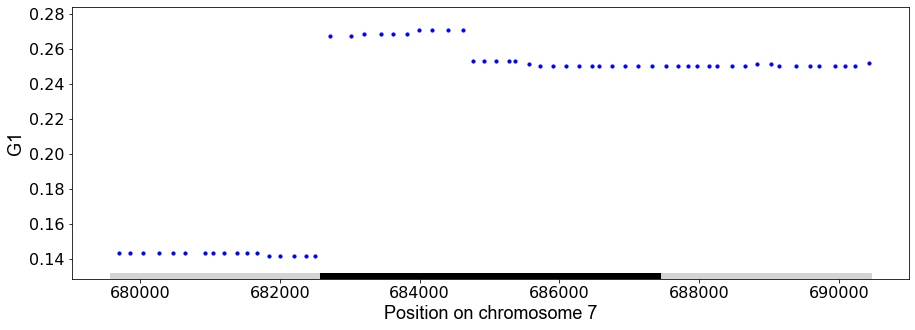

<Figure size 1080x360 with 0 Axes>

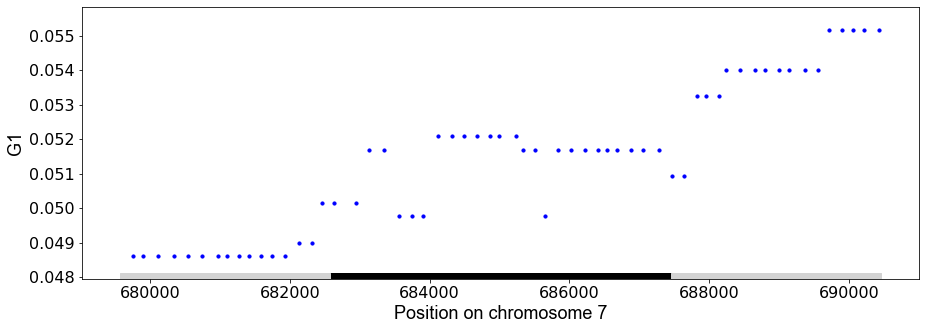

In [154]:
all_g1 = {}

g1_dir = '/Users/clairedubin/sacc/carly_genes/G1_data/'

for popdir in os.listdir(g1_dir):
    
    if popdir[-3:] == '_G1':
        
        pop = popdir[:-3]

        for chrom in range(1,17):
            
            all_g1[chrom] = ParseG1('/Users/clairedubin/sacc/carly_genes/G1_data/{}/merged_{}_chromosome{}.h12_h2h1'.format(popdir, pop, str(chrom)))
            
        g1 = make_df(all_g1)
        
        make_g1_plot(g1, ['YGR098C'], title=pop+'_ESP1')
        

In [76]:
#get loci to use in haplotype heat map

temp_dict = {}

temp_dict[7] = ParseG1('/Users/clairedubin/sacc/carly_genes/G1_data/1WineEuropean_G1/merged_1WineEuropean_chromosome7.h12_h2h1')
    
chrom7_g1 = make_df(temp_dict)

chrom, start, stop, direction = annotation_dict['YGR098C']

locs = chrom7_g1[(chrom7_g1['chrom']==int(chrom)) & chrom7_g1['pos'].isin(range(int(start),int(stop)))]
locs = locs[locs['G1'] > 0]
locs

,pos,G1,chrom
3564,682674,0.047236,7
3565,682979,0.047251,7
3566,683164,0.057401,7
3567,683423,0.057645,7
3568,683583,0.062361,7
3569,683798,0.063551,7
3570,683957,0.063551,7
3571,684150,0.063658,7
3572,684376,0.067397,7
3573,684592,0.067367,7


In [77]:
locs.to_csv('/Users/clairedubin/sacc/carly_genes/ESP1_G1_loci.csv')